# 🦠🧪Covid-19 Vaccine Distribution 🧪🦠

Optimising a vaccine distribution plan for the UK in response to the Covid-19 virus.

### Import Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon, LineString
from scipy.spatial import Voronoi
import Voronoi2D
import shapely.ops
from matplotlib.patches import Polygon as matPoly
import pandas as pd
import numpy as np
import _pickle as pickle
from selenium import webdriver
from  geopy.geocoders import Nominatim
import time
from shapely.geometry import Point
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
infected = pd.read_excel('Data//Historic COVID-19 Dashboard Data.xlsx', sheet_name='UTLAs', skiprows=7)
deaths = pd.read_excel('Data//COVID-19-total-announced-deaths-10-April-2020.xlsx', sheet_name='COVID19 total deaths by trust', skiprows=15)
population_density = pd.read_csv('Data//UK_population_densities.csv')
population = pd.read_csv('Data//UK_populations.csv')

### Creating geo-objects for UK regions

Here we will use the Selenium package to get UK region polygon data from openstreetmap.

In [3]:
# Open Chrome client
driver = webdriver.Chrome(executable_path='/Users/newuser/Desktop/Programming/C19_VaccineDistribution/Notebooks/chromedriver')

In [4]:
def get_poly_id(region):
    '''Returns the openstreetmap ID for a given region'''
    driver.get('https://nominatim.openstreetmap.org/')
    search_box = driver.find_element_by_id('q')
    search_box.send_keys(region + ' UK')
    driver.find_element_by_class_name('btn-primary').click()
    driver.find_element_by_link_text('details').click()
    poly_id = driver.find_elements_by_xpath("//a[contains(@href, 'relation')]")[0].get_attribute("href").split('/')[-1]
    return(poly_id)
    
def get_poly(poly_id):
    '''Returns a list of lat/lon strings for a given openstreetmap ID'''
    driver.get('http://polygons.openstreetmap.fr/')
    search_box = driver.find_element_by_id('id')
    search_box.send_keys(poly_id)
    driver.find_elements_by_xpath("//input[@type='submit']")[0].click()
    poly_id = driver.find_elements_by_xpath("//a[contains(@href, 'get_poly')]")[0].click()
    texts = driver.find_element_by_tag_name("body").text.split('END')
    texts = [text.split('\n') for text in texts]
    polys = [[tuple(map(float,coord.lstrip(' ').split(' '))) for coord in t if len(coord.lstrip(' ').split(' ')) == 2] for t in texts[:-2]]
    return(polys)

We have commented out the following (Raw NBconvert) to stop it doing the scrape again. Just load in the pickle file.

Mistakes found with Polygons:
    - Manchester -> Greater Manchester [Apparently these are different]
    - Cornwall and Isles of Scilly -> (Cornwall).union(Isles of Scilly) [Was missing out Cornwall with original]
    - Bedford -> Bedford UK [Was originally using the US version of Bedford]

In [5]:
with open('polygons.pkl', 'rb') as f:
    polygons = pickle.load(f)
print(f'Collected {len(polygons)} out of {len(infected)}')

Collected 151 out of 151


### Plotting UK regions

In [6]:
def draw_screen_poly( lats, lons, m, color):
    x, y = m( lons, lats )
    xy = zip(x,y)
    if type(color)==np.float64:
        poly = matPoly( list(xy), facecolor=plt.cm.viridis(color))
    else:
        poly = matPoly( list(xy), facecolor=plt.cm.autumn_r(color) if type(color)==float else color , alpha=0.4 )
    plt.gca().add_patch(poly)

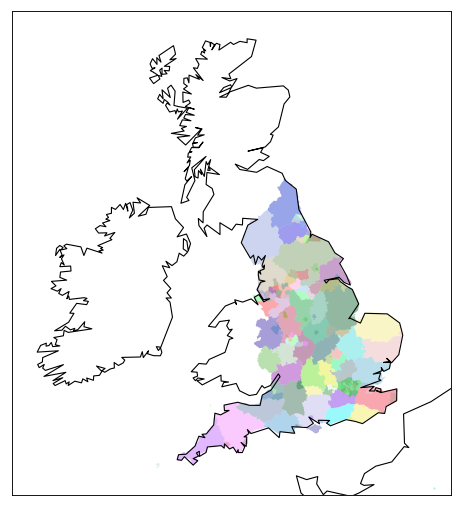

In [7]:
def plot_uk(set_of_polygons, region_colours = [], coords_of_hospitals={}, only_in_poly=False, lat0=54.3, lon0=-4, w=10e5, h=11e5, res='l'):
    plt.figure(figsize=(12, 8), dpi=80)
    m = Basemap(projection='gnom', lat_0=lat0, lon_0=lon0, width=w, height=h, resolution=res)
    m.drawcoastlines()

    if only_in_poly:
        total_poly = Polygon(polygons[set_of_polygons[-2]][0])
    
    for k,P in enumerate(set_of_polygons):
        if P == 'England ':
            continue
        for p in polygons[P]:
            if only_in_poly:
                try:
                    total_poly = total_poly.union(Polygon(p).buffer(0))
                except:
                    None
            lats = [i[1] for i in p]
            lons = [i[0] for i in p]
            if not region_colours:
                draw_screen_poly( lats, lons, m , list(np.random.random(size=3)))
            else:
                draw_screen_poly( lats, lons, m , color = region_colours[k])
            
    for hospital in coords_of_hospitals:
        h = coords_of_hospitals[hospital]

        if not only_in_poly or Point(h).within(total_poly):
            m.scatter(h[0], h[1], color = 'k', latlon = True)

    plt.show()
    
plot_uk(polygons)

### Getting hospital regions

In [8]:
def get_coords(name):
    '''Returns the lat lon coords from google maps'''
    driver.get('https://www.google.co.uk/maps/')
    search_box = driver.find_element_by_id('searchboxinput')
    search_box.send_keys(name)
    driver.find_element_by_id('searchbox-searchbutton').click()
    time.sleep(7)
    if not driver.find_elements_by_xpath("//span[contains(@class, 'widget-pane-link')]"):
        places = driver.find_elements_by_xpath("//div[@class ='section-result-title-container']")
        if not places:
            return
        places[0].click()
        time.sleep(7)
    address = [j.text for j in driver.find_elements_by_xpath("//span[contains(@class, 'widget-pane-link')]") if j.text != ''][0]
    print(address)
    geolocator = Nominatim()
    loc = geolocator.geocode(address)
    while loc == None:
        address = ','.join(address.split(',')[1:])
        loc = geolocator.geocode(address)
        if len(address) == 0:
            print(address)
            hospital_errors.append(address)
            return
    print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)
    return((loc.latitude,loc.longitude))

In [9]:
with open('hospitals.pkl', 'rb') as f:
    hospital_locs = pickle.load(f)
print(f'Collected {len([1 for h in hospital_locs if hospital_locs[h] != None])} out of {len(deaths) - 2}.')

Collected 172 out of 172.


### Check which polygons hospitals are in

In [10]:
repeats = {}

for row in infected.itertuples():
    if row[2] == 'Unconfirmed' or row[2] == 'England ':
        continue
    for hospital in hospital_locs:
        if row[2] in polygons and hospital in hospital_locs:
            for poly in polygons[row[2]]:
                if Point(hospital_locs[hospital]).within(Polygon(poly)):
                    if hospital not in repeats:
                        repeats[hospital] = [row[2]]
                    else:
                        repeats[hospital] += [row[2]]

In [11]:
values = list(repeats.keys())
for h in random.sample(values, 5):
    print(f'{h} in {repeats[h]}')

GEORGE ELIOT HOSPITAL NHS TRUST in ['Warwickshire']
TAMESIDE AND GLOSSOP INTEGRATED CARE NHS FOUNDATION TRUST in ['Manchester', 'Tameside']
GUY'S AND ST THOMAS' NHS FOUNDATION TRUST in ['Lambeth', 'Lewisham', 'Southwark']
UNITED LINCOLNSHIRE HOSPITALS NHS TRUST in ['Lincolnshire', 'Nottinghamshire']
GLOUCESTERSHIRE HOSPITALS NHS FOUNDATION TRUST in ['Gloucestershire']


There are currently multiple regions belonging to the same hospital, which shouldn't happen. This is because certain polygons contain others.

There are 2 ways for us to get round this that I can see: merge polygons with major overlap and take the union of hospitals, or take the hospital to be in the smaller of the 2 regions (since it mostly likely provides for that region). We will go for the second option for now as it seems easier and keeps the most infomation.

In [12]:
hospitalRegion = {}

for hospital in repeats:
    i = np.argmin([sum([Polygon(p).area for p in polygons[r]]) for r in repeats[hospital]])
    hospitalRegion[hospital] = repeats[hospital][i]

We now have a map from hospitals to regions.

In [13]:
values = list(hospitalRegion.keys())
for h in random.sample(values, 5):
    print(f'{h} in {hospitalRegion[h]}')

ROYAL BERKSHIRE NHS FOUNDATION TRUST in Reading
THE ROYAL ORTHOPAEDIC HOSPITAL NHS FOUNDATION TRUST in Birmingham
UNIVERSITY HOSPITALS OF NORTH MIDLANDS NHS TRUST in Stoke-on-Trent
THE CHRISTIE NHS FOUNDATION TRUST in Manchester
HUMBER TEACHING NHS FOUNDATION TRUST in East Riding of Yorkshire


### Merge Data

Here we will take data from all tables, format it nicely, and add our metrics.

In [14]:
## The following regions were labelled different to population tables.
region_map = {'Kingston upon Hull, City of': 'Hull', 'Herefordshire, County of': 'Herefordshire',
             'Bristol, City of': 'Bristol', 'Brighton and Hove': 'Brighton & Hove',
             'Cornwall and Isles of Scilly': 'Cornwall', 'St. Helens': 'St Helens',
             'Hackney and City of London': 'Hackney'}
rev_region_map = {v:k for k,v in region_map.items()}

In [15]:
df_I = infected.iloc[:,[1,-1]]
df_I.columns = ['Region', 'Infected']

df_I = df_I.replace({"Region": region_map})

df_PD = population_density[['District','Ceremonial county','Density (per km²)']]
df_PD.columns = ['Region','County','Density']
counties = df_PD.groupby('County', as_index=False).mean().rename(columns = {'County':'Region'})
df_PD = pd.concat([df_PD[['Density','Region']], counties])

df_I = df_I.merge(df_PD, on='Region', how='left')

df_P = population[['District','Ceremonial county','Population']]
df_P.columns = ['Region','County','Population']
counties = df_P.groupby('County', as_index=False).mean().rename(columns = {'County':'Region'})
df_P = pd.concat([df_P[['Population','Region']], counties])

df_I = df_I.merge(df_P, on='Region', how='left')

df_I = df_I.replace({"Region": rev_region_map})

df_D = deaths[['Name', 'Total']]
df_D.columns = ['Hospital', 'Deaths']
df_D = df_D[~df_D.isnull().T.all()] # Remove null lines
df_D['Region'] = [hospitalRegion[hospital] if hospital in hospitalRegion else float('nan') for hospital in df_D['Hospital']]

df = df_I.merge(df_D[['Region', 'Deaths']].groupby('Region', as_index=False).sum(), on='Region', how='left')

We are left with about 50 out of 160 regions that don't have deaths associated with them. Need to check these out.

In [16]:
unknown = df[df['Deaths'].isnull()]
display(unknown.head())
print(f'{len(unknown)} unknown deaths out of {len(df)}')

,Region,Infected,Density,Population,Deaths
0,Unconfirmed,2455,NaN,NaN,NaN
1,Hartlepool,64,997.0,93242.0,NaN
3,Redcar and Cleveland,139,558.0,136718.0,NaN
6,Halton,159,1624.0,128432.0,NaN
8,Blackburn with Darwen,106,1087.0,148942.0,NaN


56 unknown deaths out of 183


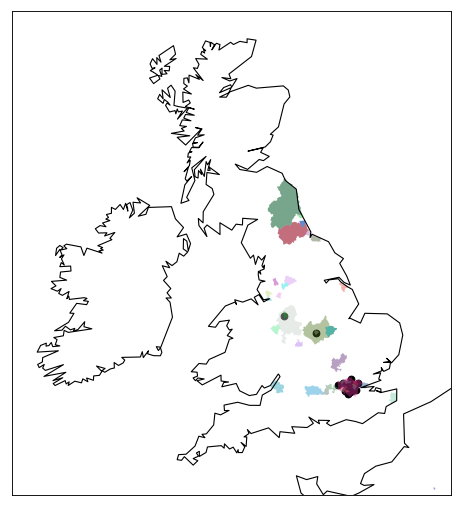

In [17]:
plot_uk(list(df[df['Deaths'].isnull()]['Region']), coords_of_hospitals=hospital_locs, only_in_poly=True)

Notice how regions that have hospitals in them but no deaths, are because that hospital is in a smaller region inside.

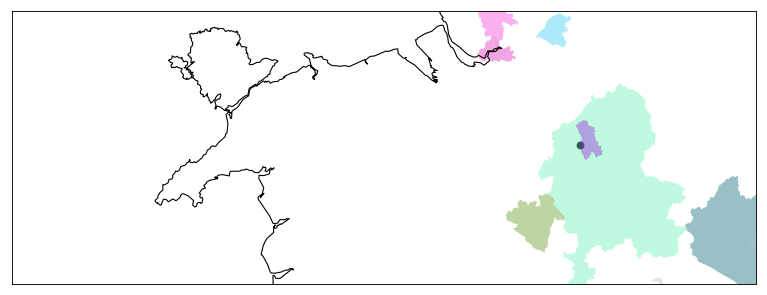

In [18]:
plot_uk(list(df[df['Deaths'].isnull()]['Region']), coords_of_hospitals=hospital_locs, lon0=-3.4, lat0=53, w=3e5, h = 11e4, res='h', only_in_poly=True)

For now we will just remove them...

In [19]:
df = df[~df['Deaths'].isnull()]

In [20]:
df

,Region,Infected,Density,Population,Deaths
2,Middlesbrough,235,2608.000000,140545.000000,78.0
4,Stockton-on-Tees,173,962.000000,197213.000000,20.0
5,Darlington,109,540.000000,106566.000000,64.0
7,Warrington,241,1160.000000,209547.000000,29.0
9,Blackpool,108,3997.000000,139305.000000,30.0
...,...,...,...,...,...
177,Suffolk,360,824.400000,151711.200000,11.0
178,Surrey,1238,1126.727273,108175.818182,348.0
179,Warwickshire,513,560.000000,114202.000000,71.0
180,West Sussex,363,1285.571429,122693.142857,107.0


### New Metrics

Now we can add our metrics!

In [21]:
df['Mortality'] = df['Deaths'] / df['Infected']
df['Morbidity'] = df['Infected'] / df['Population']

In [22]:
df

,Region,Infected,Density,Population,Deaths,Mortality,Morbidity
2,Middlesbrough,235,2608.000000,140545.000000,78.0,0.331915,0.001672
4,Stockton-on-Tees,173,962.000000,197213.000000,20.0,0.115607,0.000877
5,Darlington,109,540.000000,106566.000000,64.0,0.587156,0.001023
7,Warrington,241,1160.000000,209547.000000,29.0,0.120332,0.001150
9,Blackpool,108,3997.000000,139305.000000,30.0,0.277778,0.000775
...,...,...,...,...,...,...,...
177,Suffolk,360,824.400000,151711.200000,11.0,0.030556,0.002373
178,Surrey,1238,1126.727273,108175.818182,348.0,0.281099,0.011444
179,Warwickshire,513,560.000000,114202.000000,71.0,0.138402,0.004492
180,West Sussex,363,1285.571429,122693.142857,107.0,0.294766,0.002959


### Plots

In [23]:
def normalize(x):
    return(list((x - np.min(x)) / (np.max(x) - np.min(x))))

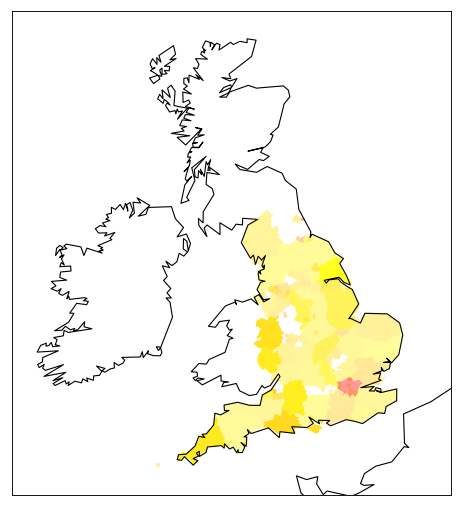

In [24]:
plot_uk(df['Region'], region_colours=normalize(df['Mortality']))

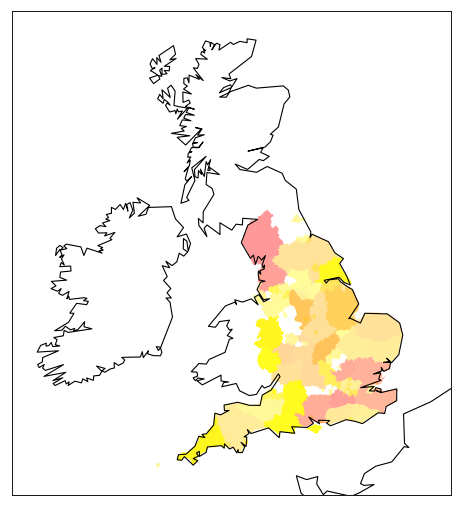

In [25]:
plot_uk(df['Region'], region_colours=normalize(df['Morbidity']))

### Clustering

In [26]:
X = StandardScaler().fit_transform(df[['Infected','Density','Deaths','Mortality','Morbidity']])
kmeans = KMeans(n_clusters=4).fit(X)

In [27]:
severity = []
for x in X:
    predict_me = np.array(x.astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    severity.append(kmeans.predict(predict_me)[0])

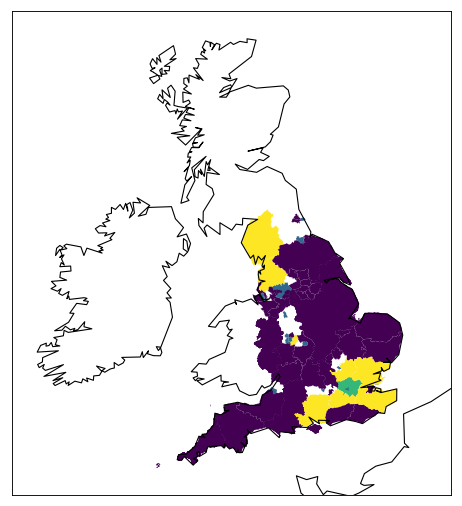

In [28]:
plot_uk(df['Region'], region_colours=normalize(severity))

### Voronoi diagram

First union all polygons to give a single UK polygon. [TAKES TIME]

In [29]:
'''
R = list(polygons.keys())[1:-1]
england_poly = Polygon(polygons[R[0]][0])
for r in R:
    for p in polygons[r]:
        try:
            england_poly = england_poly.union(Polygon(p).buffer(0))
        except:
            continue
            
with open('england_poly.pkl', 'wb') as f:
    pickle.dump(england_poly, f, protocol=-1)
'''

"\nR = list(polygons.keys())[1:-1]\nengland_poly = Polygon(polygons[R[0]][0])\nfor r in R:\n    for p in polygons[r]:\n        try:\n            england_poly = england_poly.union(Polygon(p).buffer(0))\n        except:\n            continue\n            \nwith open('england_poly.pkl', 'wb') as f:\n    pickle.dump(england_poly, f, protocol=-1)\n"

In [30]:
with open('england_poly.pkl', 'rb') as f:
    england_poly = pickle.load(f)

With the hospitals on, this looks as follows:

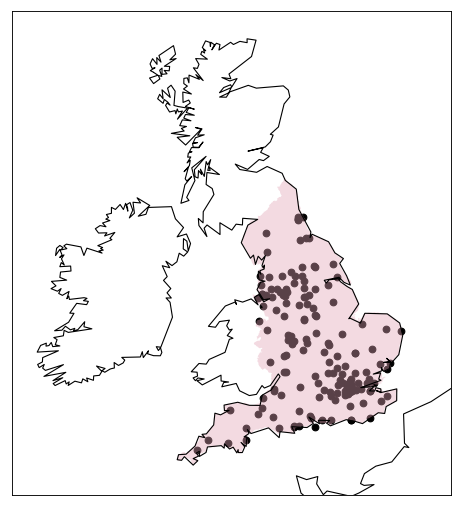

In [31]:
plt.figure(figsize=(12, 8), dpi=80)
m = Basemap(projection='gnom', lat_0=54.3, lon_0=-4, width=10e5, height=11e5, resolution='l')
m.drawcoastlines()

P = england_poly[0]
lats = [i[1] for i in P.exterior.coords]
lons = [i[0] for i in P.exterior.coords]
draw_screen_poly( lats, lons, m , list(np.random.random(size=3)))

for hospital in hospital_locs:
    h = hospital_locs[hospital]
    m.scatter(h[0], h[1], color = 'k', latlon = True)

plt.show()

Then get the Voronoi diagram of the hospitals intersected with this polygon.

In [32]:
hospitals = list(hospital_locs.keys())
points = np.array([hospital_locs[h] for h in hospitals])

vor = Voronoi(points)

regions, vertices = Voronoi2D.voronoi_finite_polygons_2d(vor, radius = 0.1)

vor_polys = {}
for i,r in enumerate(regions):
    P = Polygon([c for c in vertices[r]]).intersection(england_poly)
    if type(P) != Polygon:
        vor_polys[hospitals[i]] = [p for p in P]
    else:
        vor_polys[hospitals[i]] = [P]

And plot the resulting polygons:

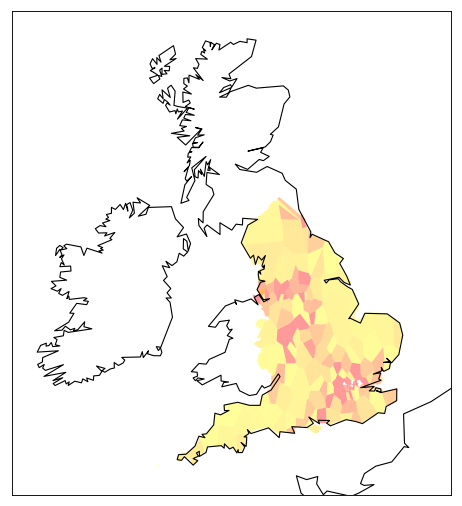

In [33]:
hospital_deaths = {h:d for h,d in zip(df_D['Hospital'],df_D['Deaths'])}

plt.figure(figsize=(12, 8), dpi=80)
m = Basemap(projection='gnom', lat_0=54.3, lon_0=-4, width=10e5, height=11e5, resolution='l')
m.drawcoastlines()

for P in vor_polys:
    areas = [p.area for p in vor_polys[P]]
    total_area = sum(areas)
    for i, p in enumerate(vor_polys[P]):
        c = (hospital_deaths[P] * (areas[i] / (total_area ** 2))) / 1000
        x,y = p.exterior.xy
        draw_screen_poly( y, x, m , color=c)

plt.show()